# **TUGAS BESAR ARTIFICIAL NEURAL NETWORK**


13521220 - Febryan Arota Hia

13521132 - Dhanika Novlisariyanti

13521153 - Made Debby Almadea Putri

13521155 - Kandida Edgina Gunawan

## **Import Library**

In [ ]:
import json
import numpy as np
import pickle

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

## **Model**

In [ ]:
class Layer:
  def __init__ (self, neuron: int, weight : np.array, bias: float, activation_func: str):
      self.neuron = neuron
      self.weight= weight
      self.bias = bias
      self.activation_function = activation_func
      valid_function = ["linear", "relu", "sigmoid", "softmax"]
      if activation_func not in valid_function:
        raise Exception("Invalid function!")

  def o_i(self, input: np.array):
    net = np.dot(input, self.weight) + self.bias
    match self.activation_function:
      case "relu":
        return np.maximum(0, net)
      case "linear":
        return net
      case "sigmoid":
        return (1/(1+np.exp((-1)*net)))
      case "softmax":
        return np.exp(net) /np.sum(np.exp(net))

  def __str__(self):
    string = f"Number of neuron: {self.neuron}\n"
    string += f"Bias: {self.bias}\n"
    string += f"Weight: \n{self.weight}\n"
    string += f"Activation function: {self.activation_function}"

    return string

In [ ]:
class FFNN:
    def __init__(self, _layers: list):
      self.layers = _layers
      self.output = None

      self.num_of_layers = len(_layers)
      self.num_of_output_neuron = None

    def addLayer(self, layer: Layer):
      self.layers.append(layer)
      self.num_of_layers += 1
      self.num_of_output_neuron = layer.neuron

    def forward(self, _input : np.array):
      print("Input =================\n")
      print(f"{_input}\n\n")
      self.output = _input
      for l in self.layers:
        self.output = l.o_i(self.output)

    def compare(self, expected_output: np.array, max_sse: float):
      if self.output is None:
        self.forward()

      if (len(expected_output) == 0):
        raise Exception("Expected output length can't be zero")

      if (len(expected_output) != len(self.output)):
        raise Exception(f"Expected output length is {len(expected_output)}, while output length is {len(self.output)}")

      if (len(expected_output[0]) != self.num_of_output_neuron):
        raise Exception(f"Expected output neuron is {len(expected_output[0])}, while output neuton is {self.num_of_output_neuron}")

      sse = 0
      for i in range(len(self.output)):
        for j in range(self.num_of_output_neuron):
          sse += pow(self.output[i][j] - expected_output[i][j], 2)

      return sse <= max_sse, sse

    def __str__(self):
      # string = "Input =================\n"
      # string += f"{_input}\n\n"
      string= ""
      for i in range(self.num_of_layers):
        string += f"Layer {i} =================\n"
        string += str(self.layers[i]) + "\n\n"

      string += "Output =================\n"
      string += f"{self.output}"

      return string

In [ ]:
class Visualizer:
    def __init__(self, _model: FFNN, _input):
      self.model = _model
      self.G = nx.DiGraph()

      # styling
      self.input_layer_color = "mediumblue"
      self.hidden_layer_color = "darkviolet"
      self.output_layer_color = "crimson"
      self.bias_node_color = "slategrey"
      self.node_label_color = "white"
      self.node_size = 800
      self._input = _input

    def show(self):
      self.G.clear()

      # add layers
      for i in range(self.model.num_of_layers):
        layer = self.model.layers[i]
        if i == 0:
          to_label = "h1"
          if self.model.num_of_layers == 1:
            to_label = "o"
          self._addLayer(i, layer, "i", to_label, node_type="input")
        elif i < self.model.num_of_layers - 1:
          to_label = f"h{i+1}"
          if (i == self.model.num_of_layers - 1):
            to_label = "o"
          self._addLayer(i, layer, f"h{i}", f"h{i+1}")
        else:
          self._addLayer(i, layer, f"h{i}", "o")

      # add outputs
      for i in range(self.model.num_of_output_neuron):
        self._addNode(f"o{i+1}", self.model.num_of_layers + 1, node_type="output")

      # position layout
      pos = nx.multipartite_layout(self.G, subset_key="level")

      # color map for each node
      color_map = []

      for node in self.G:
        node_type = self.G.nodes[node]['node_type']
        if node_type == "input":
          color_map.append(self.input_layer_color)
        elif node_type == "hidden":
          color_map.append(self.hidden_layer_color)
        elif node_type == "output":
          color_map.append(self.output_layer_color)
        else:
          color_map.append(self.bias_node_color)

      # fig size
      fig_width = self.model.num_of_layers * 3
      fig_height = max([l.neuron for l in self.model.layers] + [len(self._input[0])]) * 2

      # draw graphs
      plt.figure(figsize=(fig_width, fig_height))
      nx.draw(self.G, pos,
              with_labels=True,
              node_size=self.node_size,
              node_color=color_map,
              edge_color="grey",
              font_color=self.node_label_color,
              font_size=10,
              font_weight="semibold")

      edge_labels = dict([((n1, n2), self.G[n1][n2]['weight'])
                    for n1, n2 in self.G.edges])
      nx.draw_networkx_edge_labels(self.G, pos,
                                   edge_labels=edge_labels,
                                   label_pos=0.8,
                                   font_size=10)
      plt.show()

    def _addLayer(self, level: int, layer: Layer, fr_label: str, to_label: str, node_type: str = "hidden"):
      for fr in range(len(layer.weight)):
        self._addNode(f"{fr_label}{fr+1}", level=level, node_type=node_type)
        for to in range(len(layer.weight[fr])):
          w = layer.weight[fr][to]
          self._addEdge(f"{fr_label}{fr+1}", f"{to_label}{to+1}", w)

      # bias
      self._addNode(f"b{level+1}", level, node_type="bias")
      for i in range(len(layer.bias)):
        w = layer.bias[i]
        self._addEdge(f"b{level+1}", f"{to_label}{i+1}", w)

    def _addNode(self, label: str, level: int = 0, node_type="hidden"):
      self.G.add_node(label, level=level, node_type=node_type)

    def _addEdge(self, fr: str, to: str, weight: int):
      self.G.add_edge(fr, to, weight=weight)

In [ ]:
class IO:
  def read(self, file: str) -> FFNN:
    input = open(file, "r")
    input = json.load(input)

    layers = input["case"]["model"]['layers']

    inputNode = input["case"]["input"]

    weights = input["case"]["weights"]

    arr_input = np.array(inputNode)
    model = FFNN([])

    for i in range(len(layers)):
      neuron = layers[i]['number_of_neurons']
      activation_func = layers[i]['activation_function']
      weight = np.array(weights[i][1:])
      bias = np.array(weights[i][0])
      layer = Layer(neuron, weight, bias, activation_func)
      model.addLayer(layer)

    expected_output = input["expect"]["output"]
    max_sse = input["expect"]["max_sse"]

    model.forward(arr_input)
    print(str(model))

    print("\nPREDICT =================")
    passed, sse = model.compare(expected_output, max_sse)

    print(f"SSE: {sse}")
    print(f"MAX SSE: {max_sse}")

    if passed:
      print("PASS")
    else:
      print("NOT PASS")

    visualizer = Visualizer(model, arr_input)
    visualizer.show()

    return model, expected_output, max_sse

Input =================

[[-1.    1.    2.8   1.8  -0.45  0.24  0.15  0.2 ]]


Layer 0 =================
Number of neuron: 3
Bias: [ 0.1  0.9 -0.1]
Weight: 
[[-0.2  0.8  0.2]
 [ 0.3 -0.7  0.3]
 [ 0.4  0.6 -0.4]
 [ 0.5  0.5  0.5]
 [-0.6  0.4  0.6]
 [-0.7 -0.3  0.7]
 [ 0.8  0.2 -0.8]
 [ 0.9 -0.1  0. ]]
Activation function: softmax

Output =================
[[0.76439061 0.21168068 0.02392871]]

PREDICT =================
SSE: 1.2639167733980301e-17
MAX SSE: 1e-05
PASS


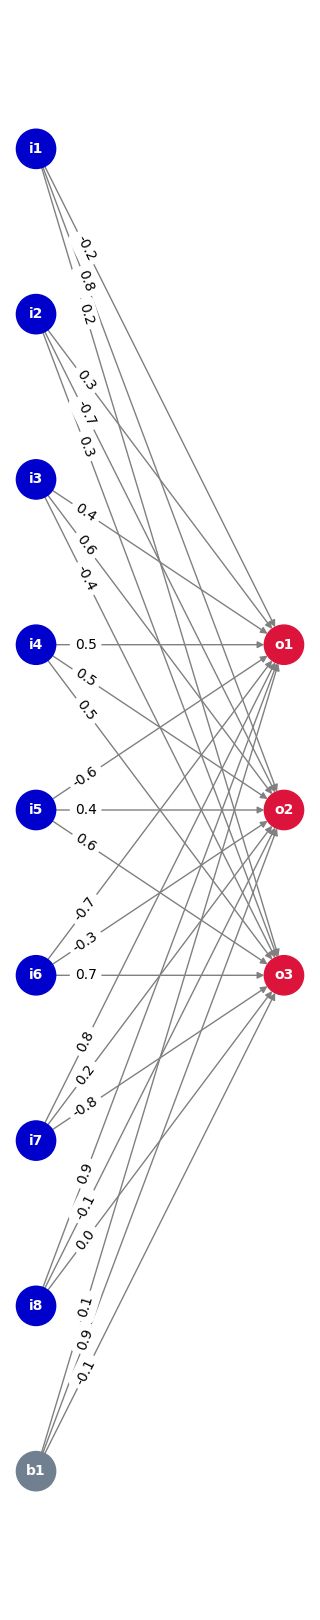

In [ ]:
io = IO()
model, expected_output, max_sse = io.read("data/softmax.json")

Input =================

[[ 1.5  -0.45]]


Layer 0 =================
Number of neuron: 3
Bias: [0.1 0.2 0.3]
Weight: 
[[ 0.47 -0.6   0.2 ]
 [ 1.1  -1.3   0.5 ]]
Activation function: relu

Output =================
[[0.31  0.    0.375]]

PREDICT =================
SSE: 3.0814879110195774e-33
MAX SSE: 1e-06
PASS


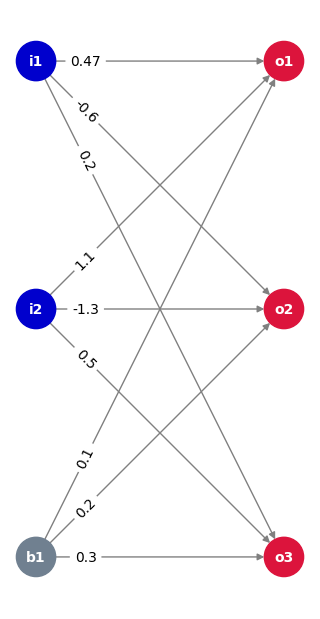

In [ ]:
io = IO()
model, expected_output, max_sse = io.read("data/relu.json")

Input =================

[[-4.]
 [-3.]
 [-2.]
 [-1.]
 [ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]]


Layer 0 =================
Number of neuron: 1
Bias: [1.]
Weight: 
[[3.]]
Activation function: linear

Output =================
[[-11.]
 [ -8.]
 [ -5.]
 [ -2.]
 [  1.]
 [  4.]
 [  7.]
 [ 10.]
 [ 13.]
 [ 16.]]

PREDICT =================
SSE: 0.0
MAX SSE: 1e-12
PASS


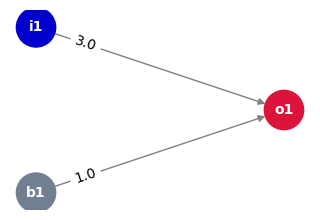

In [ ]:
io = IO()
model, expected_output, max_sse = io.read("data/linear.json")

Input =================

[[-1.   0.5  0.8]]


Layer 0 =================
Number of neuron: 4
Bias: [ 0.1  0.2  0.3 -1.2]
Weight: 
[[-0.5  0.6  0.7  0.5]
 [ 0.9  1.  -1.1 -1. ]
 [ 1.3  1.4  1.5  0.1]]
Activation function: relu

Layer 1 =================
Number of neuron: 3
Bias: [0.1 0.1 0.3]
Weight: 
[[-0.4  0.5  0.6]
 [ 0.7  0.4 -0.9]
 [ 0.2  0.3  0.4]
 [-0.1  0.2  0.1]]
Activation function: relu

Layer 2 =================
Number of neuron: 2
Bias: [0.1 0.2]
Weight: 
[[-0.3  0.4]
 [ 0.6  0.1]
 [ 0.1 -0.4]]
Activation function: relu

Layer 3 =================
Number of neuron: 1
Bias: [0.1]
Weight: 
[[-0.2]
 [ 0.3]]
Activation function: sigmoid

Output =================
[[0.4846748]]

PREDICT =================
SSE: 3.1555534707211278e-18
MAX SSE: 1e-06
PASS


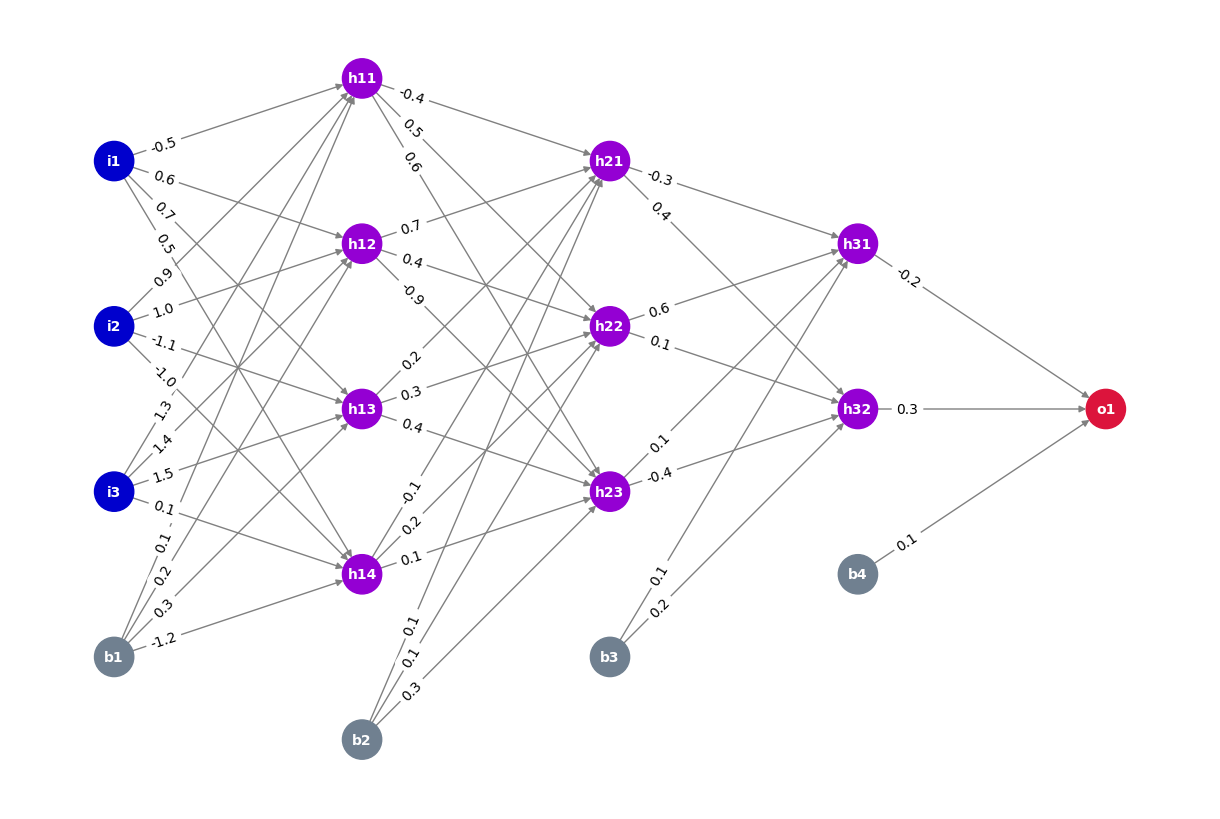

In [ ]:
model, expected_output, max_sse = io.read("data/multilayer.json")

Input =================

[[-1.    1.    2.8   1.8  -0.45  0.24  0.15  0.2 ]]


Layer 0 =================
Number of neuron: 3
Bias: [ 0.1  0.9 -0.1]
Weight: 
[[-0.2  0.8  0.2]
 [ 0.3 -0.7  0.3]
 [ 0.4  0.6 -0.4]
 [ 0.5  0.5  0.5]
 [-0.6  0.4  0.6]
 [-0.7 -0.3  0.7]
 [ 0.8  0.2 -0.8]
 [ 0.9 -0.1  0. ]]
Activation function: softmax

Output =================
[[0.76439061 0.21168068 0.02392871]]

PREDICT =================
SSE: 1.2639167733980301e-17
MAX SSE: 1e-05
PASS


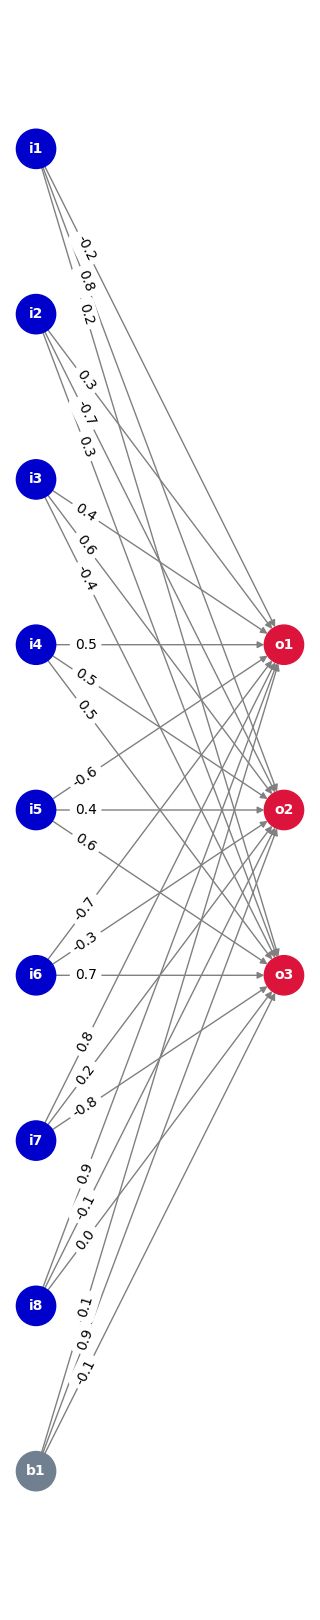

In [ ]:
model, expected_output, max_sse = io.read("data/softmax.json")

Input =================

[[ 0.1 -0.8  1.   1.2]]


Layer 0 =================
Number of neuron: 4
Bias: [-0.9  1.2 -0.6  0.3]
Weight: 
[[ 0.8 -0.7  1.1 -1.2]
 [ 0.3 -1.4  0.7  1.2]
 [ 1.1 -1.3  0.9  0.4]
 [ 0.5 -0.8  1.4 -0.9]]
Activation function: relu

Layer 1 =================
Number of neuron: 4
Bias: [ 0.7 -1.1  0.2 -1.4]
Weight: 
[[ 1.3 -0.6  0.5 -1.3]
 [-1.2  0.9  1.4 -0.7]
 [ 0.6 -0.5  1.2 -1.1]
 [ 1.  -0.4  0.8 -1. ]]
Activation function: relu

Layer 2 =================
Number of neuron: 4
Bias: [-1.3  0.7 -0.8  1.3]
Weight: 
[[ 0.2 -1.   1.1 -0.6]
 [ 1.4 -0.9  0.3 -1.4]
 [-0.7  1.2 -1.1  0.5]
 [ 0.9 -0.7  1.3 -0.8]]
Activation function: relu

Layer 3 =================
Number of neuron: 2
Bias: [ 0.4 -1.1]
Weight: 
[[-1.4  0.3]
 [ 0.8  1.2]
 [ 0.1 -1.2]
 [ 1.2  1.4]]
Activation function: softmax

Output =================
[[0.7042294 0.2957706]]

PREDICT =================
SSE: 1.94228346972322e-19
MAX SSE: 1e-06
PASS


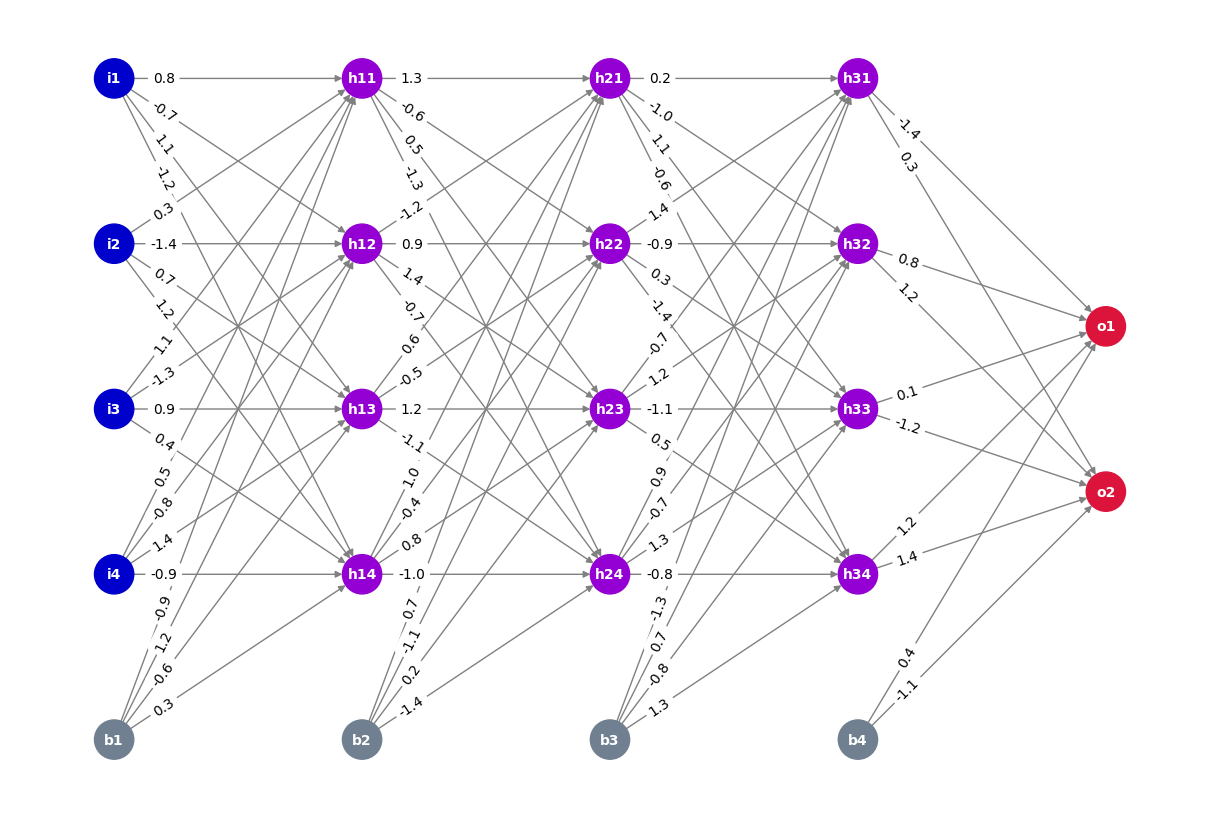

In [ ]:
model, expected_output, max_sse = io.read("data/multilayer_softmax.json")

Input =================

[[-0.6  1.6 -1. ]
 [-1.4  0.9  1.5]
 [ 0.2 -1.3 -1. ]
 [-0.9 -0.7 -1.2]
 [ 0.4  0.1  0.2]]


Layer 0 =================
Number of neuron: 2
Bias: [ 0.6 -1.2]
Weight: 
[[-1.2 -1.7]
 [ 1.4 -1.6]
 [-0.7  1.1]]
Activation function: sigmoid

Layer 1 =================
Number of neuron: 4
Bias: [-0.4  1.6  1.6 -1.5]
Weight: 
[[-0.   0.  -1.5  0.7]
 [ 2.1 -0.2  0.   1.8]]
Activation function: sigmoid

Output =================
[[0.41197346 0.8314294  0.53018536 0.31607396]
 [0.78266141 0.80843631 0.55350518 0.64278501]
 [0.58987524 0.82160954 0.75436518 0.34919895]
 [0.6722004  0.81660439 0.59020258 0.50870988]
 [0.47322841 0.82808466 0.69105452 0.29358323]]

PREDICT =================
SSE: 2.1756063348585544e-16
MAX SSE: 1e-06
PASS


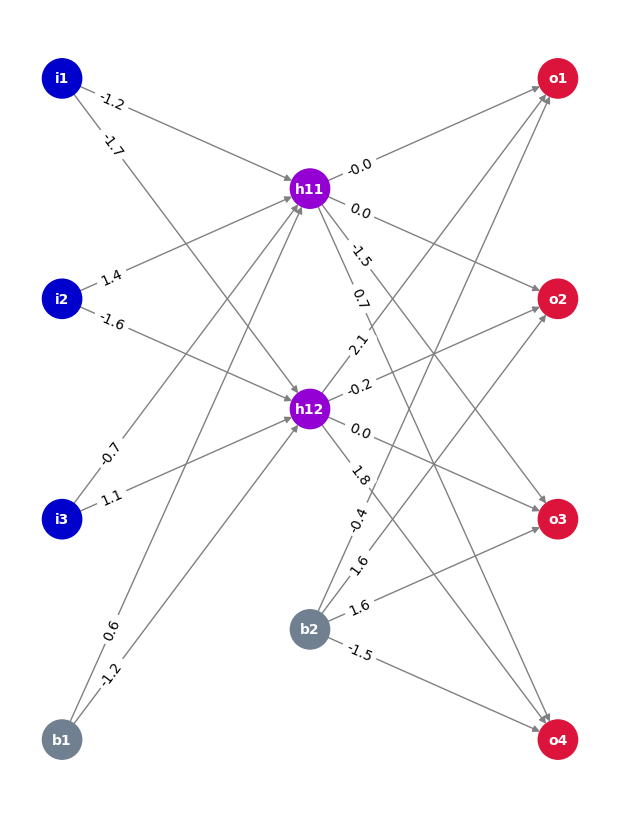

In [ ]:
model, expected_output, max_sse = io.read("data/sigmoid.json")

## **Export Model**

In [ ]:
input = open("data/softmax.json", "r")
input = json.load(input)

layers = input["case"]["model"]['layers']
print(f"layers: {layers}")

inputNode = input["case"]["input"]
print(f"input: {inputNode}")

weights = input["case"]["weights"]
print(f"weights: {weights}")  #weight[0] itu bias

input = np.array(inputNode)
layersInput = []
for i in range(len(layers)):
  neuron = layers[i]['number_of_neurons']
  activation_func = layers[i]['activation_function']
  weight = np.array(weights[i][1:])
  bias = np.array(weights[i][0])
  layer = Layer(neuron, weight, bias, activation_func)
  layersInput.append(layer)

model = FFNN(layersInput)
with open('ffnn-model.pkl', 'wb') as file:
    pickle.dump(model, file)

layers: [{'number_of_neurons': 3, 'activation_function': 'softmax'}]
input: [[-1.0, 1.0, 2.8, 1.8, -0.45, 0.24, 0.15, 0.2]]
weights: [[[0.1, 0.9, -0.1], [-0.2, 0.8, 0.2], [0.3, -0.7, 0.3], [0.4, 0.6, -0.4], [0.5, 0.5, 0.5], [-0.6, 0.4, 0.6], [-0.7, -0.3, 0.7], [0.8, 0.2, -0.8], [0.9, -0.1, 0.0]]]


## **Load Model**

In [ ]:
with open('ffnn-model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

loaded_model.forward(input)
loaded_model.output

Input =================

[[-1.    1.    2.8   1.8  -0.45  0.24  0.15  0.2 ]]




array([[0.76439061, 0.21168068, 0.02392871]])

## **Test**

In [ ]:
input = open("data/softmax.json", "r")
input = json.load(input)

layers = input["case"]["model"]['layers']
print(f"layers: {layers}")

inputNode = input["case"]["input"]
print(f"input: {inputNode}")

weights = input["case"]["weights"]
print(f"weights: {weights}")  #weight[0] itu bias

input = np.array(inputNode)
model = FFNN([])

for i in range(len(layers)):
  neuron = layers[i]['number_of_neurons']
  activation_func = layers[i]['activation_function']
  weight = np.array(weights[i][1:])
  bias = np.array(weights[i][0])
  layer = Layer(neuron, weight, bias, activation_func)
  model.addLayer(layer)

model.forward(input)
model.output

layers: [{'number_of_neurons': 3, 'activation_function': 'softmax'}]
input: [[-1.0, 1.0, 2.8, 1.8, -0.45, 0.24, 0.15, 0.2]]
weights: [[[0.1, 0.9, -0.1], [-0.2, 0.8, 0.2], [0.3, -0.7, 0.3], [0.4, 0.6, -0.4], [0.5, 0.5, 0.5], [-0.6, 0.4, 0.6], [-0.7, -0.3, 0.7], [0.8, 0.2, -0.8], [0.9, -0.1, 0.0]]]
Input =================

[[-1.    1.    2.8   1.8  -0.45  0.24  0.15  0.2 ]]




array([[0.76439061, 0.21168068, 0.02392871]])

## **Test Visualize**

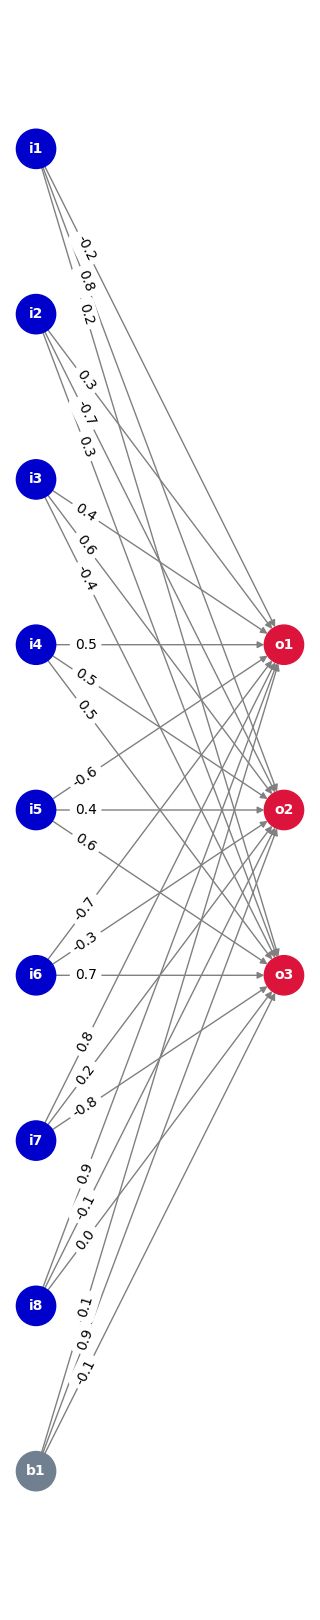

In [ ]:
visualizer = Visualizer(model, input)
visualizer.show()